In [3]:
import numpy as np

In [69]:
import distribution_modules as dm
import density_estimation_modules as dem
import classification_modules as cm
import importlib

importlib.reload(dm)
importlib.reload(dem)
importlib.reload(cm)

<module 'classification_modules' from 'C:\\Users\\shfar\\Desktop\\SU\\Thesis\\thesis\\classification_modules.py'>

In [36]:
# set configurations
sample_size = 500
nr_sample = 20
num_steps = 10
x_b = np.linspace(0,1,num_steps)
x_h = np.linspace(0,20,num_steps)

# cv config
test_size = 0.2
cv = 5
cv_config = [test_size, cv]

### Bounded distributions

In [5]:
bounded_dists = dm.get_bounded_distribution()
bounded_samples = dm.get_samples(bounded_dists, nr_sample, sample_size)
#dm.plot_histograms_of_samples(bounded_samples)

In [6]:
kde_df = dem.get_kde(bounded_samples, x_b)
kde_df.head(3)

,0,1,2,3,4,5,6,7,8,9,dist
0,0.916544,1.050745,0.819521,0.652317,0.639844,0.721324,0.743977,0.827170,1.051907,0.851083,arcsine
1,0.931997,1.136721,0.923491,0.701273,0.568638,0.527061,0.618318,0.841344,1.067043,0.886817,arcsine
2,0.856801,1.102027,0.891634,0.690130,0.618604,0.594511,0.665190,0.825394,1.069321,0.937792,arcsine


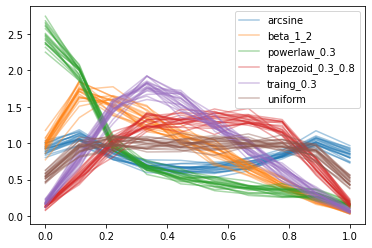

In [7]:
dem.get_kde_plot(kde_df,x_b)

### SVM

In [12]:
sample_size_list = [5, 10, 25, 50, 100, 200, 500, 750, 1000]
num_steps_list = list(np.arange(5,200,5))

In [54]:
acc, std = cm.cv_numsteps_samplesize(sample_size_list, num_steps_list, bounded_dists, 20, cv_config, 1)

% completed:   0%|          | 0/10 [00:00<?, ?it/s]

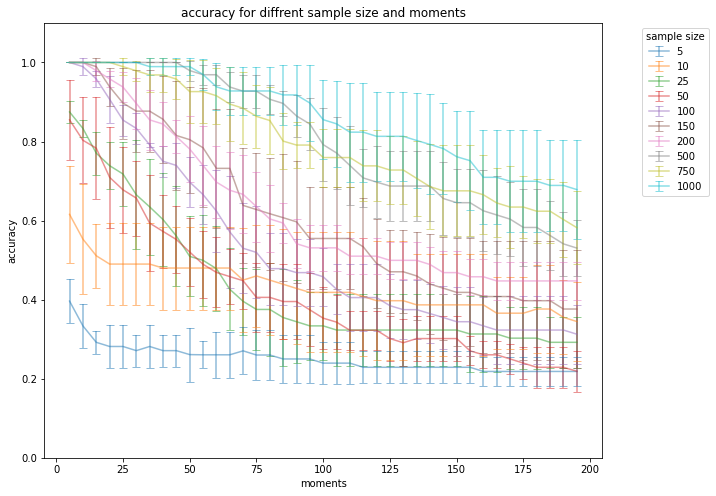

In [57]:
cm.plot_cv_moments(sample_size_list, num_steps_list, acc, std, errbar=1)

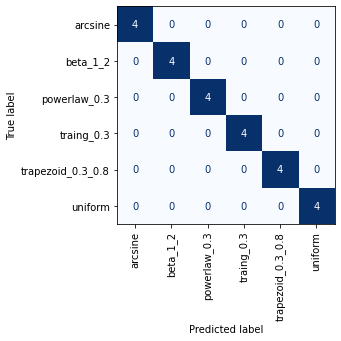

array([1., 1., 1., 1., 1.])

In [9]:
cm.svm_model(kde_df, test_size, cv, plot=1)

### Logistic Regression

In [52]:
acc, std = cm.cv_numsteps_samplesize(sample_size_list, num_steps_list, bounded_dists, 20, cv_config, 2)

% completed:   0%|          | 0/10 [00:00<?, ?it/s]

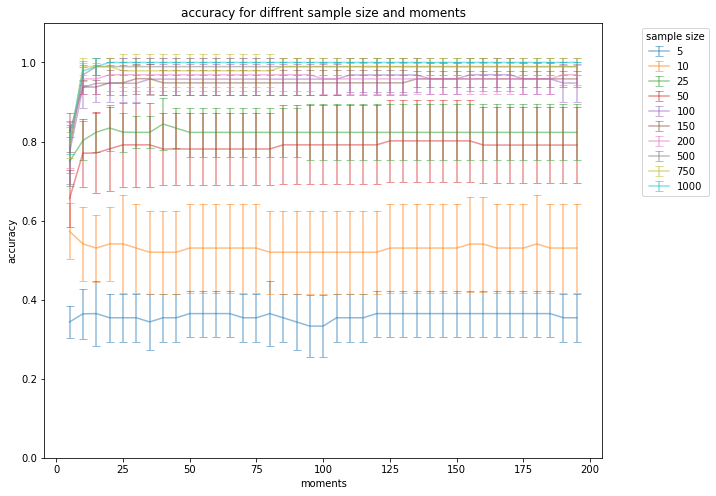

In [53]:
cm.plot_cv_moments(sample_size_list, num_steps_list, acc, std, errbar=1)

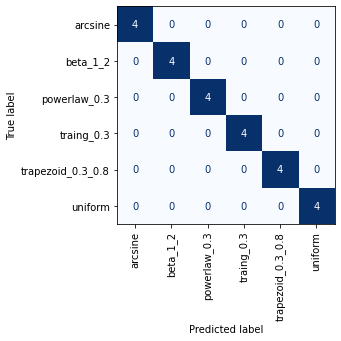

array([1.        , 0.94736842, 0.94736842, 0.94736842, 1.        ])

In [8]:
cm.rr_model(kde_df, test_size, cv, plot=1)

### Heavytail distributions

In [59]:
heavytail_dists = dm.get_heavytail_distribution()
heavytail_samples = dm.get_samples(heavytail_dists, nr_sample, sample_size)
#dm.plot_histograms_of_samples(heavytail_samples)

In [64]:
kde_df = dem.get_kde(heavytail_samples, x_h)
kde_df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,dist
0,0.127659,0.136440,0.139972,0.138024,0.131041,0.120033,0.106347,0.091413,0.076515,0.062638,...,0.001599,0.001665,0.001747,0.001824,0.001874,0.001882,0.001841,0.001752,0.001626,cauchy
1,0.042466,0.042851,0.043093,0.043189,0.043140,0.042947,0.042611,0.042138,0.041531,0.040798,...,0.012698,0.011677,0.010717,0.009816,0.008975,0.008193,0.007467,0.006796,0.006178,cauchy
2,0.089789,0.093121,0.094830,0.094853,0.093220,0.090052,0.085546,0.079957,0.073577,0.066705,...,0.002745,0.002583,0.002462,0.002372,0.002307,0.002257,0.002216,0.002181,0.002146,cauchy


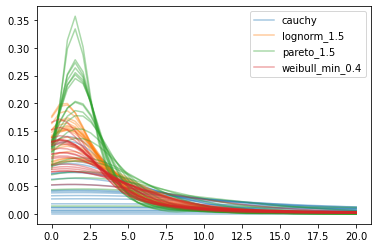

In [62]:
dem.get_kde_plot(kde_df, x_h)

### SVM

In [73]:
num_steps_list_ht = list(np.arange(5,200,5))
acc_ht, std_ht = cm.cv_numsteps_samplesize(sample_size_list, num_steps_list_ht, heavytail_dists, 20, cv_config, 1)

% completed:   0%|          | 0/10 [00:00<?, ?it/s]

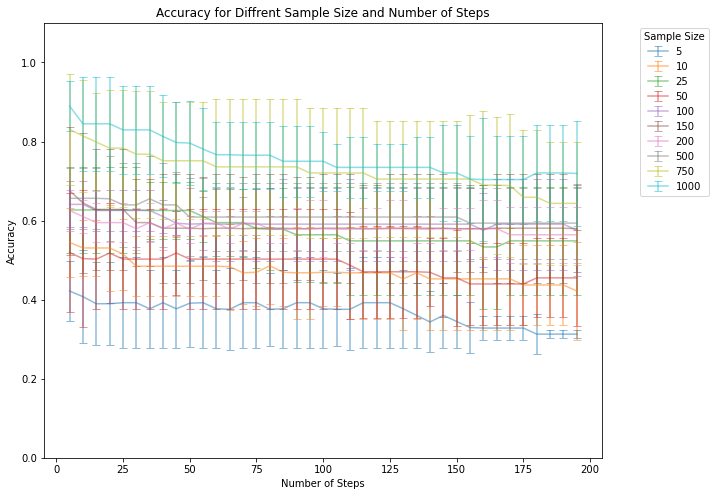

In [74]:
cm.plot_cv_numsteps_samplesize(sample_size_list, num_steps_list, acc_ht, std_ht, errbar=1)

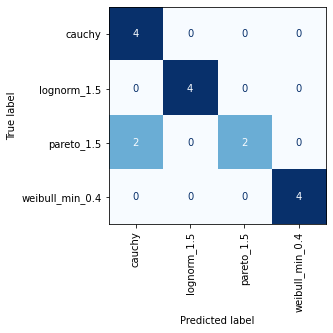

array([0.46153846, 0.84615385, 0.61538462, 0.92307692, 0.66666667])

In [39]:
cm.svm_model(kde_df, test_size, cv, plot=1)

### Logististic Regression

In [71]:
acc_rr_ht, std_rr_ht = cm.cv_numsteps_samplesize(sample_size_list, num_steps_list_ht, heavytail_dists, 20, cv_config, 2)

% completed:   0%|          | 0/10 [00:00<?, ?it/s]

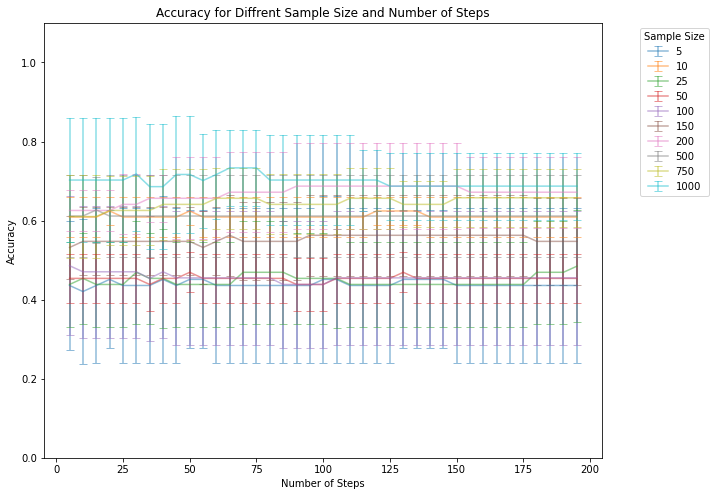

In [72]:
cm.plot_cv_numsteps_samplesize(sample_size_list, num_steps_list, acc_rr_ht, std_rr_ht, errbar=1)

In [ ]:
cm.rr_model(kde_df, test_size, cv, plot=1)